# Convolutional neural networks

## Learning objectives

- Discover the general architecture of convolutional neural networks.
- Understand why they perform better than plain neural networks for image-related tasks.
- Learn how to build convnets with [PyTorch](https://pytorch.org/).

## Environment setup

In [15]:
# pylint: disable=wrong-import-position

import os

# Installing the ainotes package is only necessary in standalone runtime environments like Colab
if os.getenv("COLAB_RELEASE_TAG"):
    print("Standalone runtime environment detected, installing ainotes package")
    %pip install ainotes

# pylint: enable=wrong-import-position

In [16]:
import platform
from IPython.display import YouTubeVideo

import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from ainotes.utils.plot import plot_loss_acc, plot_fashion_images
from ainotes.utils.train import get_device, count_parameters, fit

In [17]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [18]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")


# PyTorch device configuration
device, message = get_device()
print(message)

Python version: 3.11.1
NumPy version: 1.26.4
PyTorch version: 2.2.1
Using MPS GPU :)


## Architecture

### Justification

The visual world has the following properties:

- Translation invariance.
- Locality: nearby pixels are more strongly correlated
- Spatial hierarchy: complex and abstract concepts are composed from simple, local elements.

Classical models are not designed to detect local patterns in images.

[![Visual world](_images/visual_world.png)](https://youtu.be/shVKhOmT0HE)

### Topological structure of objects

[![Topological structure](_images/topological_structure.png)](https://youtu.be/shVKhOmT0HE)

[![From edges to objects](_images/edges_to_objects.png)](https://youtu.be/shVKhOmT0HE)

### General CNN design

[![General CNN architecture](_images/cnn_architecture.png)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

### The convolution operation

Apply a **kernel** to data. Result is called a **feature map**.

[![Convolution with a 3x3 filter of depth 1 applied on 5x5 data](_images/convolution_overview.gif)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

![Convolution example](_images/convolution_example.jpeg)

### Convolution parameters

- **Filter dimensions**: 2D for images.
- **Filter size**: generally 3x3 or 5x5.
- **Number of filters**: determine the number of feature maps created by the convolution operation.
- **Stride**: step for sliding the convolution window. Generally equal to 1.
- **Padding**: blank rows/columns with all-zero values added on sides of the input feature map.

### Preserving output dimensions with padding

[![Preserving output dimensions with padding](_images/2d_convol.gif)](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

#### Valid padding

Output size = input size - kernel size + 1

[![Valid padding](_images/padding_valid.png)](https://youtu.be/shVKhOmT0HE)

#### Full padding

Output size = input size + kernel size - 1

[![Valid padding](_images/padding_full.png)](https://youtu.be/shVKhOmT0HE)

#### Same padding

Output size = input size

[![Valid padding](_images/padding_same.png)](https://youtu.be/shVKhOmT0HE)

### Convolutions inputs and outputs

[![Convolution inputs and outputs](_images/conv_inputs_outputs.png)](https://youtu.be/shVKhOmT0HE)

### 2D convolutions on 3D tensors

- Convolution input data is 3-dimensional: images with height, width and color channels, or features maps produced by previous layers.
- Each convolution filter is a collection of *kernels* with distinct weights, one for every input channel.
- At each location, every input channel is convolved with the corresponding kernel. The results are summed to compute the (scalar) filter output for the location.
- Sliding one filter over the input data produces a 2D output feature map.

[![2D convolution on a 32x32x3 image with 10 filters](_images/conv_image.png)](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

[![2D convolution over RGB image](_images/2D_conv_over_rgb_image.png)](https://stackoverflow.com/a/44628011/2380880)

### Activation function

- Applied to the (scalar) convolution result.
- Introduces non-linearity in the model.
- Standard choice: ReLU.

### The pooling operation

- Reduces the dimensionality of feature maps.
- Often done by selecting maximum values (*max pooling*).

[![Max pooling with 2x2 filter and stride of 2](_images/maxpool_animation.gif)](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

#### Pooling result

[![Pooling result](_images/pooling_result.png)](https://youtu.be/shVKhOmT0HE)

#### Pooling output

[![Pooling with a 2x2 filter and stride of 2 on 10 32x32 feature maps](_images/maxpooling_image.png)](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)

### Training process

Same principle as a dense neural network: **backpropagation** + **gradient descent**.

[Backpropagation In Convolutional Neural Networks](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)


### Interpretation

- Convolution layers act as **feature extractors**.
- Dense layers use the extracted features to classify data.

![A convnet](_images/convnet.jpeg)

[![Feature extraction with a CNN](_images/representation_learning.png)](https://harishnarayanan.org/writing/artistic-style-transfer/)

[![Visualizing convnet layers on MNIST](_images/keras_js_layers.png)](https://transcranial.github.io/keras-js/#/mnist-cnn)

## History

### Humble beginnings: LeNet5 (1988)

![LeNet5](_images/lenet5.jpg)

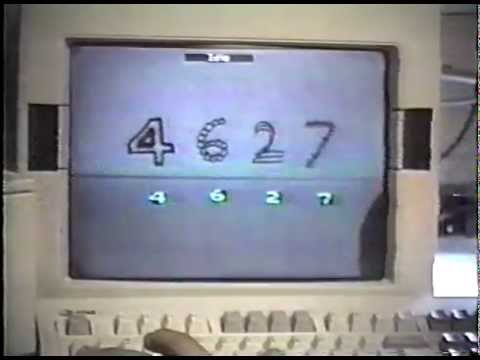

In [19]:
YouTubeVideo("FwFduRA_L6Q")

### The breakthrough: ILSVRC

- [_ImageNet Large Scale Visual Recognition Challenge_](http://image-net.org/challenges/LSVRC/)
- Worldwide image classification challenge based on the [ImageNet](http://www.image-net.org/) dataset.

![ILSVRC results](_images/ILSVRC_results.jpg)

### AlexNet (2012)

Trained on 2 GPU for 5 to 6 days.

![AlexNet](_images/alexnet2.png)

### VGG (2014)

![VGG16](_images/vgg16.png)

### GoogLeNet/Inception (2014)

- 9 Inception modules, more than 100 layers.
- Trained on several GPU for about a week.

![Inception](_images/google_inception.jpg)

### Microsoft ResNet (2015)

- 152 layers, trained on 8 GPU for 2 to 3 weeks.
- Smaller error rate than a average human.

![ResNet](_images/resnet_archi.png)

![Deeper model](_images/deeper_model.jpg)

### Depth: challenges and solutions

- Challenges
  - Computational complexity
  - Optimization difficulties

- Solutions
  - Careful initialization
  - Sophisticated optimizers
  - Normalisation layers
  - Network design

## Multiclass classification example

### Data loading and visualization

The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains 70,000 28x28 grayscale images of fashion items.

It is slightly more challenging than the ubiquitous MNIST handwritten digits dataset.


In [20]:
fashion_train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

fashion_test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

In [21]:
# Labels, i.e. fashion categories associated to images (one category per image)
fashion_labels = (
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

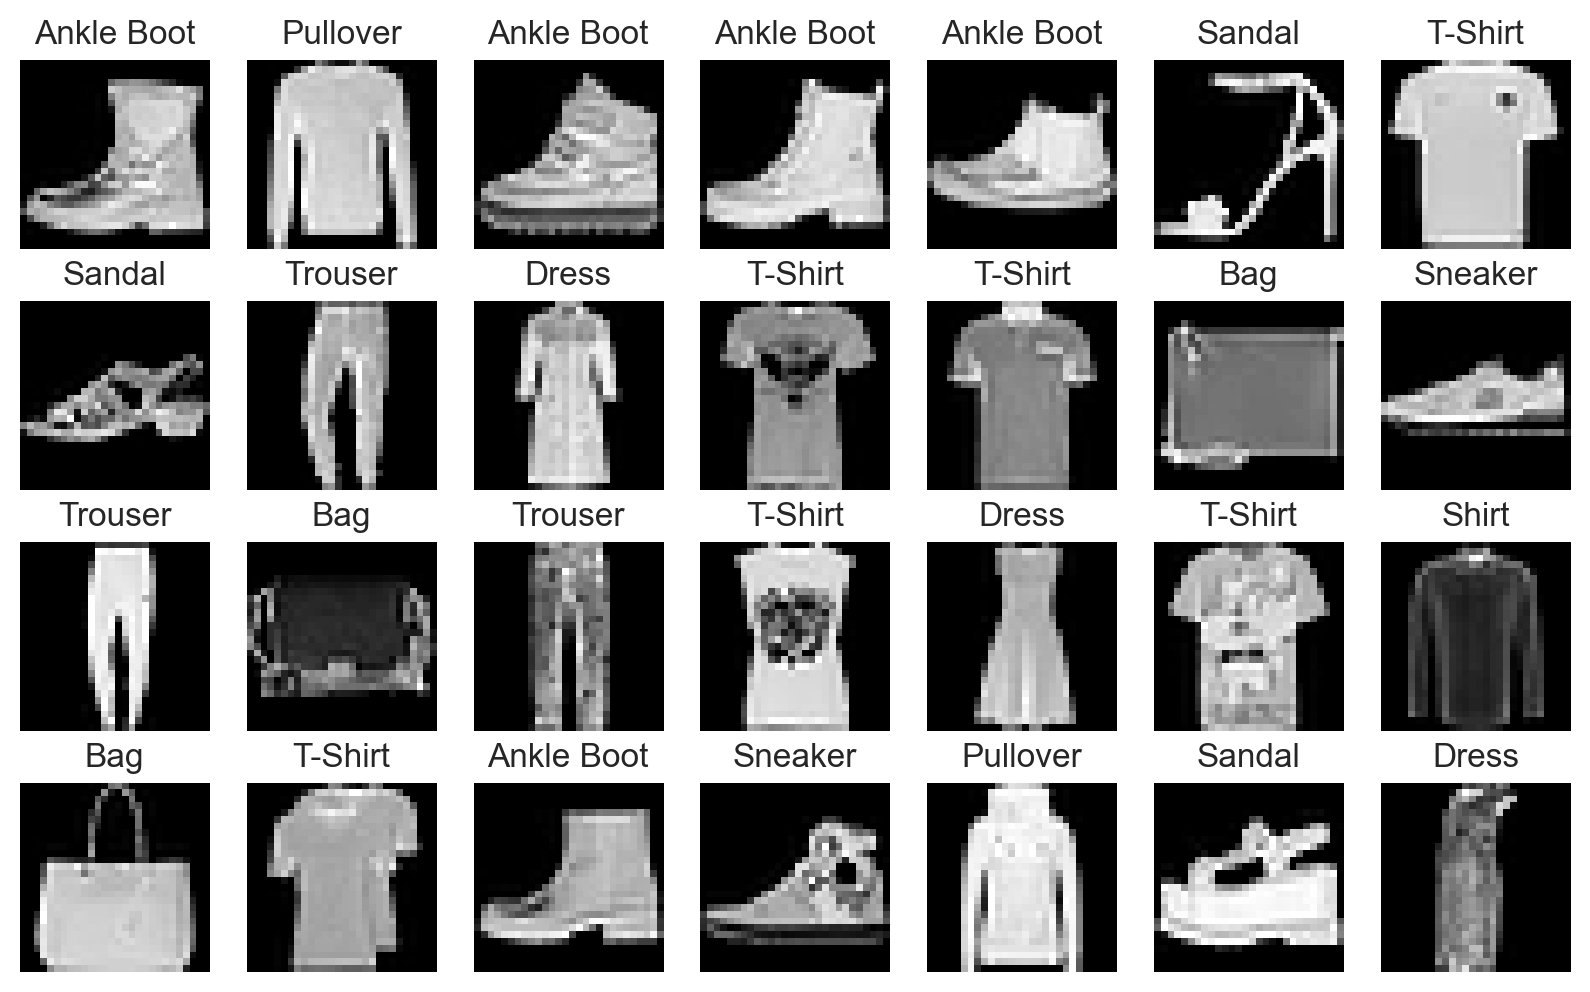

In [22]:
plot_fashion_images(data=fashion_train_data, labels=fashion_labels, device=device)

### Hyperparameters

In [23]:
learning_rate = 1e-3
n_epochs = 10
batch_size = 64

### Data preparation

In [24]:
fashion_train_dataloader = DataLoader(fashion_train_data, batch_size=batch_size)
fashion_test_dataloader = DataLoader(fashion_test_data, batch_size=batch_size)

### Model definition

#### Expected architecture

![Example CNN architecture](_images/example_cnn_architecture.png)

#### Model class

Our model leverages the following PyTorch classes:

- [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html): an ordered container of modules.
- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): for 2D convolutions.
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html): the corresponding activation function.
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): to apply max pooling.
- [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html): to flatten the extracted features into a vector.
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): fully connected layer used for final classification.

In [25]:
class Convnet(nn.Module):
    """Convnet for fashion articles classification"""

    def __init__(self):
        super().__init__()

        # Define a sequential stack
        self.layer_stack = nn.Sequential(
            # Feature extraction part, with convolutional and pooling layers
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Classification part, with fully connected layers
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [26]:
fashion_convnet = Convnet().to(device)
print(fashion_convnet)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(fashion_convnet)}")

Convnet(
  (layer_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
Number of trainable parameters: 225034


### Model training

In [27]:
fashion_history = fit(
    fashion_train_dataloader,
    fashion_convnet,
    nn.CrossEntropyLoss(),
    optim.Adam(fashion_convnet.parameters(), lr=learning_rate),
    epochs=n_epochs,
    device=device,
)

Training started! 60000 samples. 938 batches per epoch


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 109.03batches/s]


Epoch [  1/ 10] finished. Mean loss: 0.52975. Accuracy: 81.36%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 110.20batches/s]


Epoch [  2/ 10] finished. Mean loss: 0.33813. Accuracy: 88.28%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.82batches/s]


Epoch [  3/ 10] finished. Mean loss: 0.29011. Accuracy: 89.96%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.08batches/s]


Epoch [  4/ 10] finished. Mean loss: 0.25939. Accuracy: 91.00%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.78batches/s]


Epoch [  5/ 10] finished. Mean loss: 0.23431. Accuracy: 91.91%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.28batches/s]


Epoch [  6/ 10] finished. Mean loss: 0.21312. Accuracy: 92.65%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 107.65batches/s]


Epoch [  7/ 10] finished. Mean loss: 0.19300. Accuracy: 93.61%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 106.89batches/s]


Epoch [  8/ 10] finished. Mean loss: 0.17512. Accuracy: 94.27%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 110.95batches/s]


Epoch [  9/ 10] finished. Mean loss: 0.15785. Accuracy: 94.97%


100%|███████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.15batches/s]

Epoch [ 10/ 10] finished. Mean loss: 0.14234. Accuracy: 95.60%
Training complete! Total gradient descent steps: 9380


### Training results

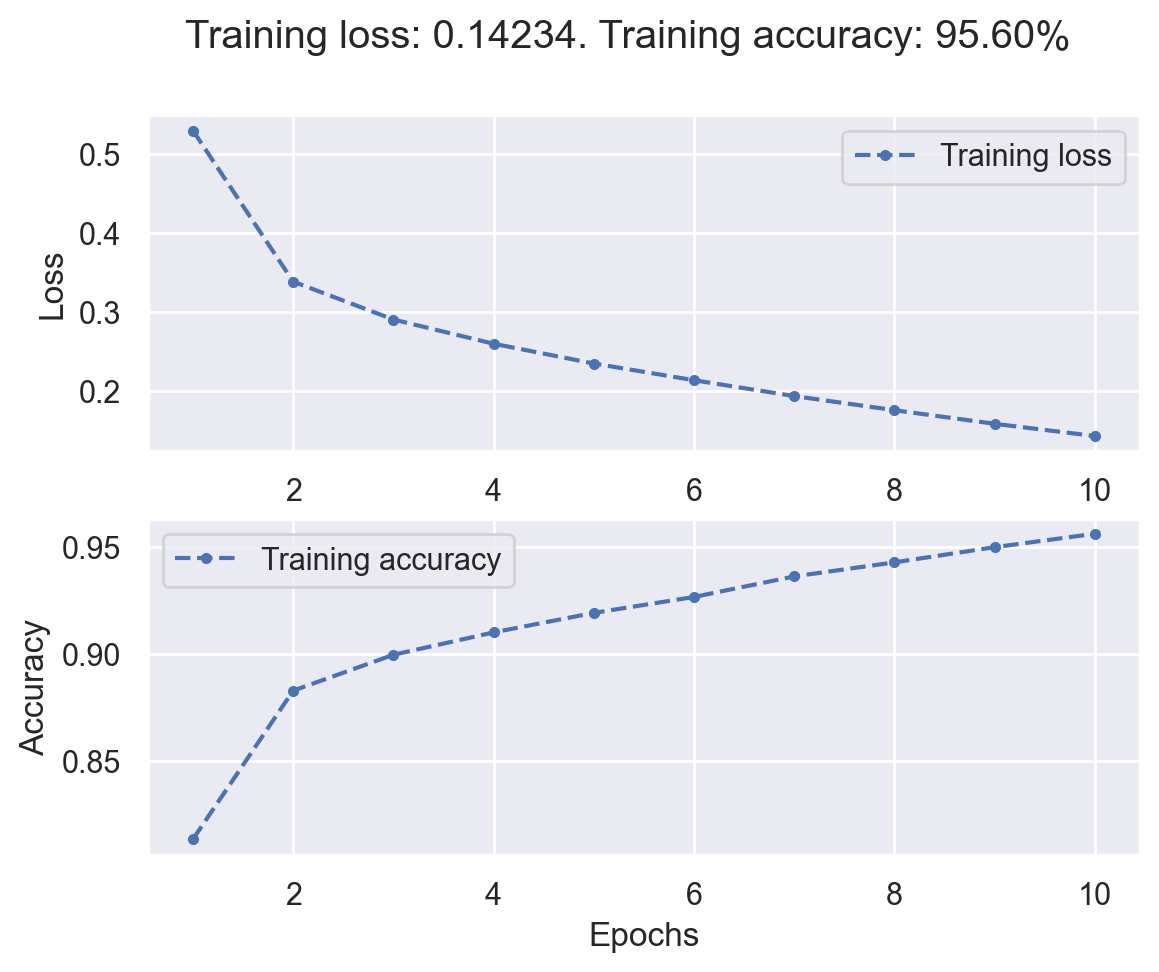

In [28]:
# Plot training history
plot_loss_acc(fashion_history)

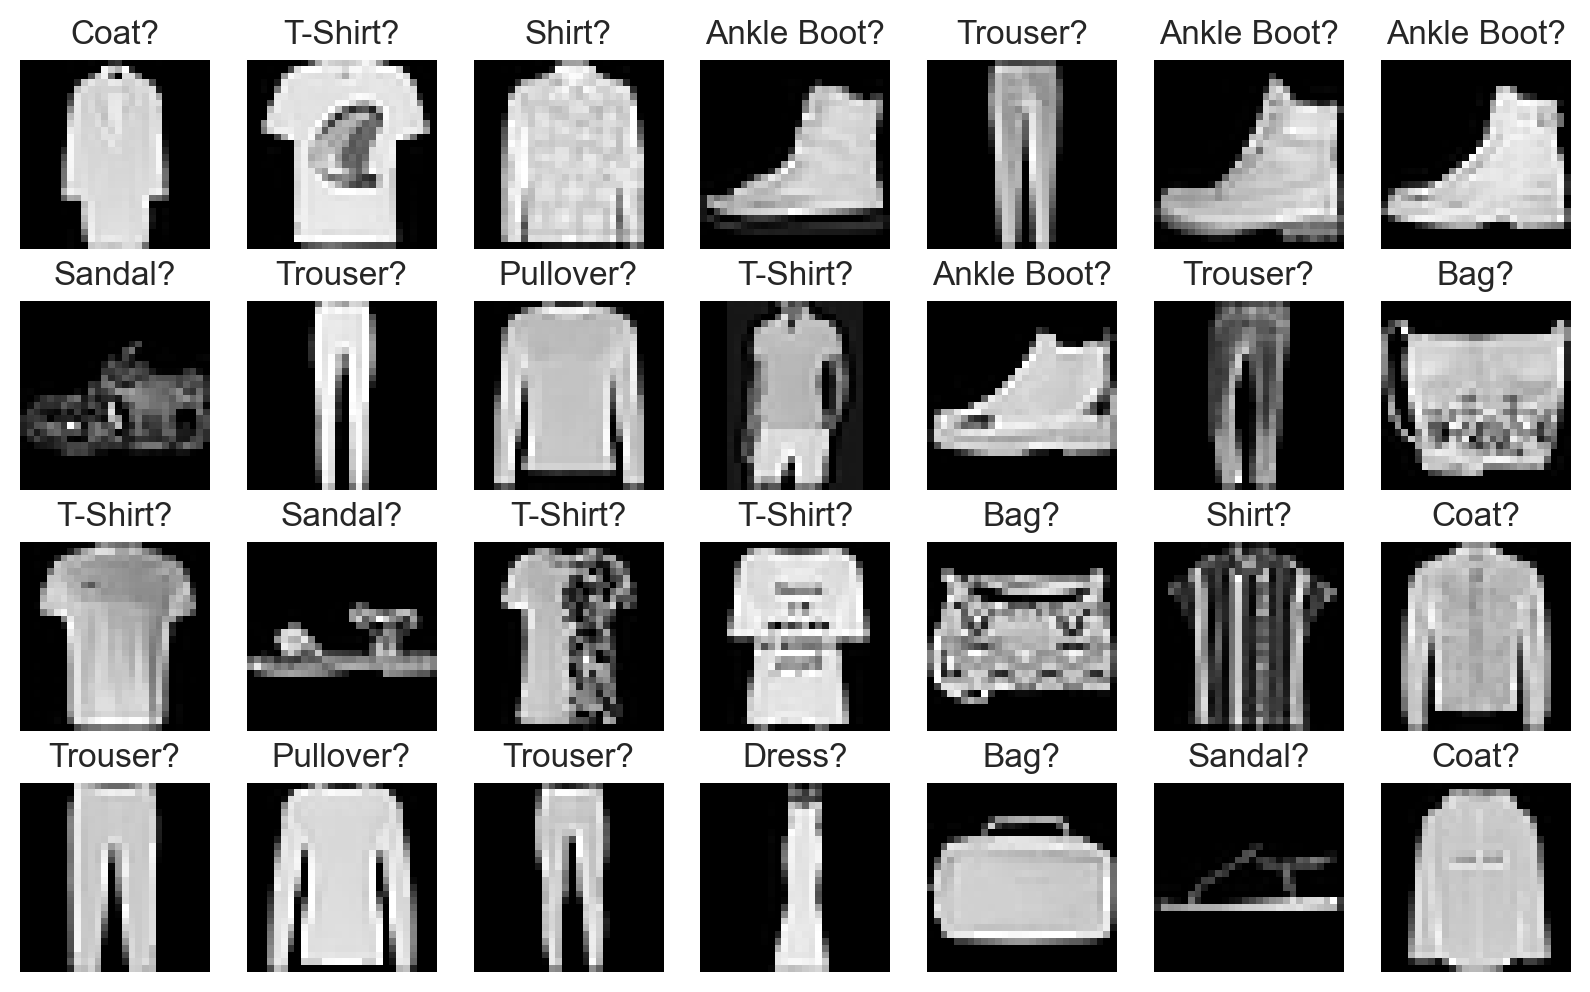

In [29]:
plot_fashion_images(
    data=fashion_train_data, labels=fashion_labels, device=device, model=fashion_convnet
)

## Using a pretrained convnet

### An efficient strategy

A *pretrained convnet* is a saved network that was previously trained on a large dataset (typically on a large-scale image classification task). If the training set was general enough, it can act as a generic model and its learned features can be useful for many problems.

It is an example of *transfer learning*.

There are two ways to use a pretrained model: *feature extraction* and *fine-tuning*.

### Feature extraction

Reuse the convolution base of a pretrained model, and add a custom classifier trained from scratch on top ot if.

State-of-the-art models (VGG, ResNet, Inception...) are regularly published by top AI institutions.

### Fine-tuning

Slightly adjusts the top feature extraction layers of the model being reused, in order to make it more relevant for the new context.

These top layers and the custom classification layers on top of them are jointly trained.

![Fine-tuning](_images/fine_tuning.png)